# Part 1: synthetic timeseries

1- In this part we are generating synthetic timeseries in decimal year between $1850.0$ and $2020.0$ using the **synthetic.py** module, that contains a single harmonic component of period $10 years$, and is evenly sampled every $12th$ of a year (i.e. every month).

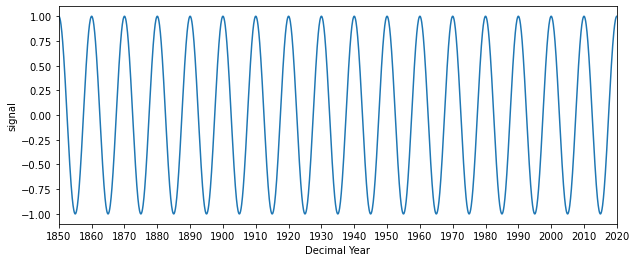

In [29]:
# Import notebook dependencies

import os
import sys
import numpy as np
#%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from synthetic import *

time_start = 1850.0
time_end = 2020.0
t_samp = 1./12.

# define synthetic time series
timewindow = def_timewindow(time_start, time_end, t_samp)
period = 10. # in year
amp = 1.
phase = -2*np.pi*time_start/period
tseries = cos_ts(timewindow, period, amp, phase)

# plot it
fig = plt.figure( figsize = (10, 4) ) #figsize can be adjusted to your needs
plt.plot(timewindow, tseries)
plt.xlabel('Decimal Year')
plt.ylabel('signal')
plt.xlim(time_start,time_end)
plt.xticks(np.linspace(time_start, time_end, endpoint = True, num = int( (time_end - time_start)/10 + 1 ) ) ) 
# show the figure
plt.show()

2- Then, we perform a $spectral$ $analysis$ of the signal ${s(t)}$ and therefore we compute its (discrete) Fourier transform. 

Let ${\hat{s}(f)}$ denote this transform, with ${f}$ the frequency (inverse of the period) - keeping in mind that the angular frequency ${\omega=2{\pi}{f}}$.
To compute $\hat{s}$ we resort to python again, in particular to the **fft.rfft function**. An example of its usage is given in the piece of code below, where the spectral analysis is performed on the harmonic example I gave above.

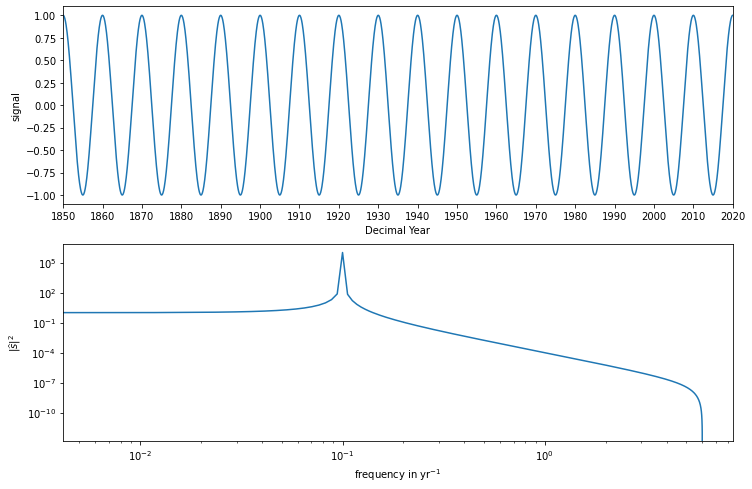

In [38]:
# compute its Fourier transform
s_hat = np.fft.rfft(tseries) # 
# these are the associated frequencies (useful for subsequent plot)
freq = np.fft.rfftfreq(len(tseries),t_samp) # in year^{-1} 
# plot the timeseries and its power spectrum 
fig = plt.figure( figsize=(12,8) )
#
ax1 = fig.add_subplot(211)
ax1.plot(timewindow, tseries)
ax1.set_xlabel('Decimal Year')
ax1.set_ylabel('signal')
ax1.set_xlim(time_start, time_end)
ax1.set_xticks(np.linspace(time_start, time_end, endpoint = True, num = int((time_end - time_start)/10 + 1 )))
#
ax2 = fig.add_subplot(212)
ax2.loglog(freq, abs(s_hat)**2)
ax2.set_xlabel('frequency in yr$^{-1}$')
ax2.set_ylabel(r'|$\widehat{s}$|$^2$')
# show the figure
plt.show()

3- Now let us get acquainted with the ${Butterworth}$ filters provided by the **signal** processing package of scientific python. 

The code below shows how to apply a $bandpass$ $filter$, with corner periods equal to ${5}$ and $15$ yr, to the example timeseries I have been using so far.

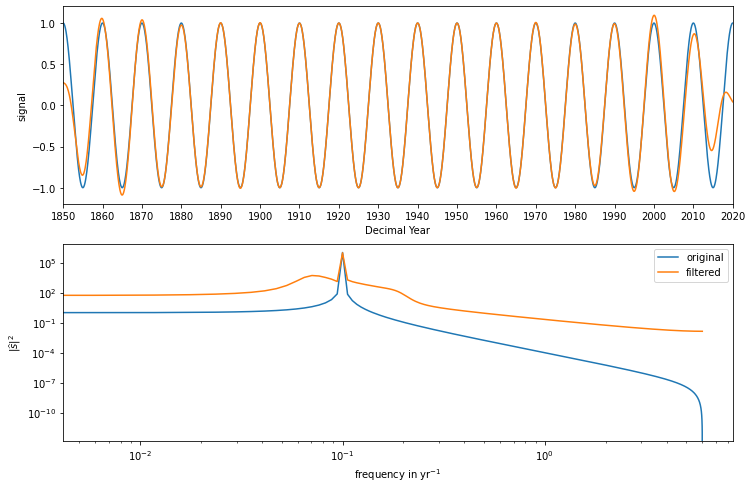

In [39]:
from scipy import signal 

# define Butterworth filter properties
#
# The frequency band [w_low_cut,w_high_cut] is given as a fraction of the 
# Nyquist Frequency which is equal to half of the sampling frequency
# 
T_long  = 15 # in yr
T_short = 5  # in yr
#
f_samp = 1./t_samp   
f_nyq =  f_samp / 2
#
f_low_cut =  (1./T_long)          # in year^{-1}
w_low_cut =  f_low_cut / f_nyq    # angular frequency
#
f_high_cut = (1./T_short)         # in year^{-1}
w_high_cut = f_high_cut / f_nyq   # angular frequency

# define filter properties
#
b,a = signal.butter(4, [w_low_cut,w_high_cut], 'band')
#
# apply filter to signal (twice, to avoid phasing) 
#
recons = signal.filtfilt(b,a,tseries)
#
# compute its Fourier transform
#
recons_hat = np.fft.rfft(recons)
#
# plot the timeseries and its power spectrum, as well as those
# of the filtered signal 
#
fig = plt.figure( figsize = (12, 8) )
#
ax1 = fig.add_subplot(211)
ax1.plot(timewindow, tseries)
ax1.plot(timewindow, recons)
ax1.set_xlabel('Decimal Year')
ax1.set_ylabel('signal')
ax1.set_xlim(time_start,time_end)
ax1.set_xticks(np.linspace(time_start, time_end, endpoint = True, num = int( (time_end - time_start)/10 + 1 )) )
#
ax2 = fig.add_subplot(212)
ax2.loglog(freq, abs(s_hat)**2, label="original")
ax2.loglog(freq, abs(recons_hat)**2, label="filtered")
ax2.set_xlabel('frequency in yr$^{-1}$')
ax2.set_ylabel(r'|$\widehat{s}$|$^2$')
ax2.legend()
# show the figure
plt.show()

# Part 2: Real Case 

## 1- Chambon-la-Forêt Geomagnetic Data:

${CLF}$ : Chambon-la-Forêt, where the French magnetic observatory is located since 1936. See e.g. www.bcmt.fr.

The file **clf1936-2020.dat** contains the monthly means of the geomagnetic elements recorded at the **CLF** observatory. The header of the file looks like so

    #This file is provided by the database of the "Bureau Central de   |
    #Magnetisme Terrestre" (BCMT, France).                             |
    #Conditions of use: these data are for scientific/academic use.    |
    #Formula for computing non-reported elements:                      |
    #X=H*cos(D), Y=H*sin(D), tan(I)=Z/H                                |
    #D is expressed in minutes of arc.                                 |
    #1-month values are computed from 24 monthly means of 1-hour       |
    #values.                                                           |
    #For any enquiry, please contact: bcmt@ipgp.fr                     |
    #DATE       TIME        DOY     CLFH      CLFD      CLFZ      CLFF

The bulk of Earth’s magnetic field 𝐁:(X,Y,Z) is generated in the liquid outer core, where fluid flow is influenced by Earth rotation and the geometry of the inner core. Core flow produces a Secular Variation in the magnetic field, which known as a rate of change of the field, 𝜕B∕𝜕t:(𝜕X∕𝜕t,𝜕Y∕𝜕t,𝜕Z∕𝜕t)  
 
The code below reads the file, compute and and plots the fluctuations of Earth Magnetic Field at the site between ${1936.0}$ and ${2020.0}$ decimal year. The differents computed and and plotted components are: the North component ${(X)}$, the East component ${(Y)}$, and the Vertical component ${(Z)}$ of Earth Magnetic Field, with their first time derivative componenets in the same plot: 𝜕X∕𝜕t,𝜕Y∕𝜕t and 𝜕Z∕𝜕t, respectively.


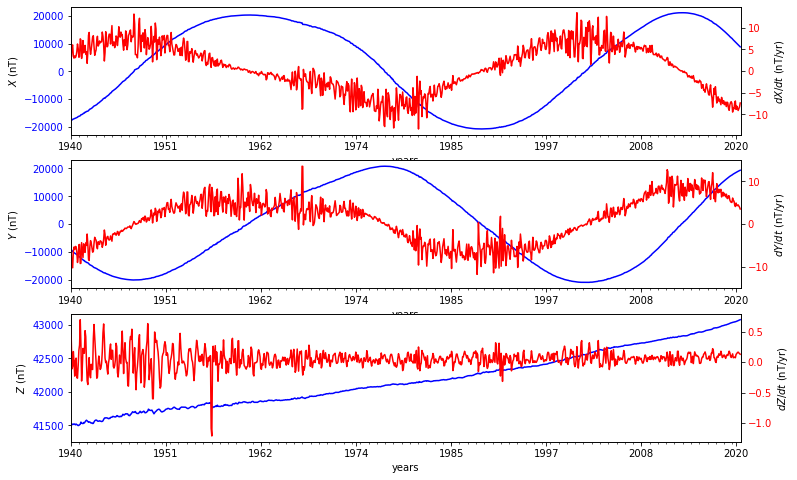

In [33]:
import matplotlib.dates as dts
import time
import math


datestr2num = lambda s: dts.datestr2num(s.decode('ascii'))
#
fname = 'clf1936-2020.dat'
#
data = np.loadtxt(fname, usecols=(0,3,4,5,6), converters={0:datestr2num})
#
epoch = data[:,0]
#
# Compute the X and Y component that connect with the horizontal component H
hcomp = data[:,1]
#
## The declination D is given in the header above in minutes of arc
# We express D in degrees
#
decl = data[:,2]/60. # declination expressed in degrees
#
zcomp = data[:,3] # being the vertical component, 
#                   which is the Earth’s rotation axis 
xcomp = hcomp*np.cos(decl) #being the Northward component,
#                          points towards Greenwich meridian, 
##                         and Y complete this system
ycomp = hcomp*np.sin(decl) #being the Easthward component
#
## The declination D is given in the header above in minutes of arc
# We express D in degrees
#
decl = data[:,2]/60. # declination expressed in degrees
#
#Calculate The SV
#np.gradient(np.sin(x), dx)

#x_sv = np.diff(xcomp)/np.diff(xcomp)
x_sv = np.gradient(xcomp,epoch)
y_sv = np.gradient(ycomp,epoch)
z_sv = np.gradient(zcomp,epoch) 
#
#
years = dts.YearLocator()          # every year
months = dts.MonthLocator()        # every month
yearsFmt = dts.DateFormatter('%Y') # format for a year

# Plot timeseries of X, Y and Z components and the corresponding 
# first derivative components, respictively.
#
fig, axs = plt.subplots(3,figsize=(12,8))
# 
# Plot timeseries of X
axs[0].plot(epoch,xcomp,color='blue')
axs[0].tick_params(axis='y', labelcolor='blue')
# Generate a new Axes instance, on the twin-X axes (same position)
ax0 = axs[0].twinx()
# Plot timeseries of dX\dt
ax0.plot(epoch,x_sv,color='red')
#ax0.set_yscale('log')
ax0.tick_params(axis='y', labelcolor='red')
# format the ticks
axs[0].xaxis.set_minor_locator(years)
axs[0].xaxis.set_major_formatter(yearsFmt)
datemin = dts.datestr2num('1940-01-01')
datemax = dts.datestr2num('2020-12-31')
axs[0].set_xlim(datemin, datemax)
axs[0].set_xticks(np.arange(datemin,datemax,4200))
axs[0].set_xlabel('years')
axs[0].set_ylabel('$X$ (nT)')
ax0.set_ylabel('$dX/dt$ (nT/yr)')
#
# Plot timeseries of Y
axs[1].plot(epoch,ycomp,color='blue')
axs[1].tick_params(axis='y', labelcolor='blue')
# Generate a new Axes instance, on the twin-X axes (same position)
ax1 = axs[1].twinx()
# Plot timeseries of dX\dt
ax1.plot(epoch,y_sv,color='red')
#ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='red')
# format the ticks
axs[1].xaxis.set_minor_locator(years)
axs[1].xaxis.set_major_formatter(yearsFmt)
datemin = dts.datestr2num('1940-01-01')
datemax = dts.datestr2num('2020-12-31')
axs[1].set_xlim(datemin, datemax)
axs[1].set_xticks(np.arange(datemin,datemax,4200))
axs[1].set_xlabel('years')
axs[1].set_ylabel('$Y$ (nT)')
ax1.set_ylabel('$dY/dt$ (nT/yr)')

# Plot timeseries of Z
axs[2].plot(epoch,zcomp,color='blue')
axs[2].tick_params(axis='y', labelcolor='blue')
# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = axs[2].twinx()
# Plot timeseries of dX\dt
ax2.plot(epoch,z_sv,color='red')
#ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='red')
# format the ticks
axs[2].xaxis.set_minor_locator(years)
axs[2].xaxis.set_major_formatter(yearsFmt)
datemin = dts.datestr2num('1940-01-01')
datemax = dts.datestr2num('2020-12-31')
axs[2].set_xlim(datemin, datemax)
axs[2].set_xticks(np.arange(datemin,datemax,4200))
axs[2].set_xlabel('years')
axs[2].set_ylabel('$Z$ (nT)')
ax2.set_ylabel('$dZ/dt$ (nT/yr)')
#
# show the figure
plt.show()

## 2- Declination $D(t)$ Measurment and its Secular Variation:
Observations of $Declination$ **D(t)** $time series$ over the years are important in characterising the scales of temporal variations in the core-generated field; constitute one of the best records of **secular variation (SV)**, allowing us easily to compute the SV in a single position (at **CLF** observatory in this work) and to estimate occurrence dates for geomagnetic jerks. 

To enhance rapid events and reduce solar cycle effects, the first time derivative is computed after applying an **11-yr** smoothing low-pass filter window which makes the changes in the trend more rounded. Nevertheless, the geomagnetic jerks can still be clearly identified.

**geomagnetic jerk:** tell-tale sign of a jerk is identified by the the sudden change in slope; shows the change in secular variation (obtained by taking the year to year change of the first plot) with time. 

The typical SV time scale spans years to centuries, and its typical magnitude is ${10-100}$ ${nT.yr^-1}$. These values help to define the observational requirements for magnetic observatories: they should run for many years, achieve measurement accuracy in all components of the field vector of around ${1 nT}$, and maintain the long-term stability needed to resolve the typical secular change signal.
With the above recommendation, the geomagnetic observatories represent a unique dataset to understand the secular variation over long-term periods. Indeed, the geomagnetic jerk was detection and identification in geomagnetic observatories series.
Seen in the plot that there have been a number of changes in the general trend of secular variation in the past, in particular at about $1969$, $1978$, $1992$, $1999$ and $2003$. These sudden changes are known as jerks or impulses and, at the present time, are not well understood and are certainly not predictable. Some researchers have found evidence for a correlation with length-of-day changes.

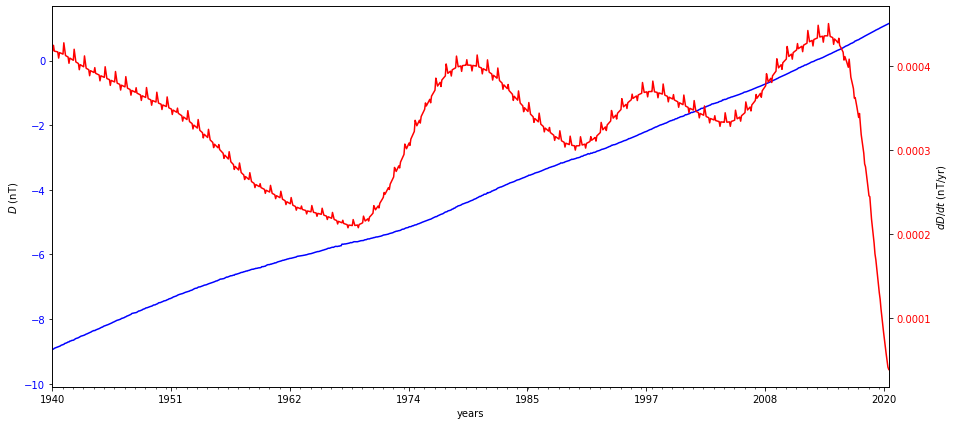

In [34]:
# Compute Secular Variation dD/dt, the first derivative of D(t) after
# Applying 11-yr smoothing low-pass filter window in D(t) 
# 
T  = 11. # in yr
f_samp = 1./t_samp   
f_nyq =  f_samp / 2
#
f_cut =  (1./T)          # in year^{-1}
w_cut =  f_cut / f_nyq    # angular frequency
#
# define filter properties
b,a = signal.butter(2, w_cut, 'low')
#
# apply filter to signal (twice, to avoid phasing) 
#
decl_fil = signal.filtfilt(b,a,decl)
#
# plot the timeseries and its power spectrum, as well as those
# of the filtered signal 
#
d_sv = np.gradient(decl_fil,epoch)
#
# Plot timeseries of D and its secular component dD/dt
#
fig, axs = plt.subplots(figsize=(15,7))
# Plot timeseries of D
axs.plot(epoch,decl,color='blue')
axs.tick_params(axis='y', labelcolor='blue')
# Generate a new Axes instance, on the twin-X axes (same position)
ax3 = axs.twinx()
# Plot timeseries of dD\dt
ax3.plot(epoch,d_sv,color='red')
#ax2.set_yscale('log')
ax3.tick_params(axis='y', labelcolor='red')
# format the ticks
axs.xaxis.set_minor_locator(years)
axs.xaxis.set_major_formatter(yearsFmt)
datemin = dts.datestr2num('1940-01-01')
datemax = dts.datestr2num('2020-12-31')
axs.set_xlim(datemin, datemax)
axs.set_xticks(np.arange(datemin,datemax,4200))
axs.set_xlabel('years')
axs.set_ylabel('$D$ (nT)')
ax3.set_ylabel('$dD/dt$ (nT/yr)')

# show the figure
plt.show()

## 3- Power Spectral Density:

Based on the expertise gained in the first synthetic part of this work, computing the (discrete) Fourier transform, in addition to plotting $X(t)$, $Y(t)$ and $Z(t)$, I compute ${\hat{X}(f)}$, ${\hat{Y}(f)}$ and ${\hat{Z}(f)}$, and I plot the Fourier spectra of the corresponding time series, in which the corresponding power spectral density are: ${|\hat{X}(f)|^2}$, ${|\hat{Y}(f)|^2}$ and ${|\hat{Z}(f)|^2}$.

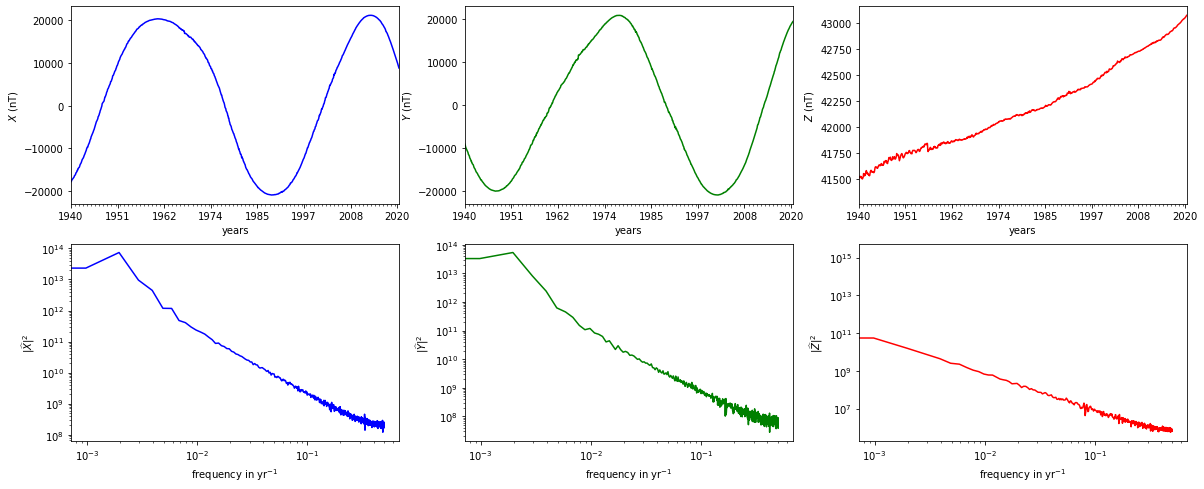

In [35]:
#  compute Fourier transform of Geomagnetic Field components
x_hat = np.fft.rfft(xcomp) 
y_hat = np.fft.rfft(ycomp) 
z_hat = np.fft.rfft(zcomp) 
# these are the associated frequencies (useful for subsequent plot)
freq_x = np.fft.rfftfreq(len(xcomp)) # in year^{-1} 
freq_y = np.fft.rfftfreq(len(ycomp))
freq_z = np.fft.rfftfreq(len(zcomp))

# plot the timeseries and its power spectrum 
fig, axs = plt.subplots(2,3, figsize=(20,8))
#

# Plot timeseries of X
axs[0,0].plot(epoch,xcomp,color='blue')
axs[0,1].plot(epoch,ycomp,color='green')
axs[0,2].plot(epoch,zcomp,color='red')
# format the ticks
axs[0,0].xaxis.set_minor_locator(years)
axs[0,1].xaxis.set_minor_locator(years)
axs[0,2].xaxis.set_minor_locator(years)
axs[0,0].xaxis.set_major_formatter(yearsFmt)
axs[0,1].xaxis.set_major_formatter(yearsFmt)
axs[0,2].xaxis.set_major_formatter(yearsFmt)
datemin = dts.datestr2num('1940-01-01')
datemax = dts.datestr2num('2020-12-31')
axs[0,0].set_xlim(datemin, datemax)
axs[0,1].set_xlim(datemin, datemax)
axs[0,2].set_xlim(datemin, datemax)
axs[0,0].set_xticks(np.arange(datemin,datemax,4200))
axs[0,1].set_xticks(np.arange(datemin,datemax,4200))
axs[0,2].set_xticks(np.arange(datemin,datemax,4200))
axs[0,0].set_xlabel('years')
axs[0,1].set_xlabel('years')
axs[0,2].set_xlabel('years')
axs[0,0].set_ylabel('$X$ (nT)')
axs[0,1].set_ylabel('$Y$ (nT)')
axs[0,2].set_ylabel('$Z$ (nT)')
#
## Plot the power spectral density of X
axs[1,0].loglog(freq_x, abs(x_hat)**2,color='blue')
axs[1,1].loglog(freq_y, abs(y_hat)**2,color='green')
axs[1,2].loglog(freq_z, abs(z_hat)**2,color='red')
axs[1,0].set_xlabel('frequency in yr$^{-1}$')
axs[1,1].set_xlabel('frequency in yr$^{-1}$')
axs[1,2].set_xlabel('frequency in yr$^{-1}$')
axs[1,0].set_ylabel(r'|$\widehat{X}$|$^2$')
axs[1,1].set_ylabel(r'|$\widehat{Y}$|$^2$')
axs[1,2].set_ylabel(r'|$\widehat{Z}$|$^2$')
# show the figure
plt.show()

## 4- Butterworth Low-Pass Filter:

The code filter out the long-period components of Earth Magnetic Field: $X(t)$, $Y(t)$ and $Z(t)$, with periods greater than 15~years. Plot the original Signal $X(t)$, $Y(t)$ and $Z(t)$,and its filtered version  $X'(t)$, $Y'(t)$ and $Z'(t)$ on one graph, and the spectra of ${|\hat{X}(f)|^2}$, ${|\hat{Y}(f)|^2}$ and ${|\hat{Z}(f)|^2}$ and ${|\hat{X'}(f)|^2}$, ${|\hat{Y'}(f)|^2}$ and ${|\hat{Z'}(f)|^2}$ on a second row (both graphs on the same plot). 

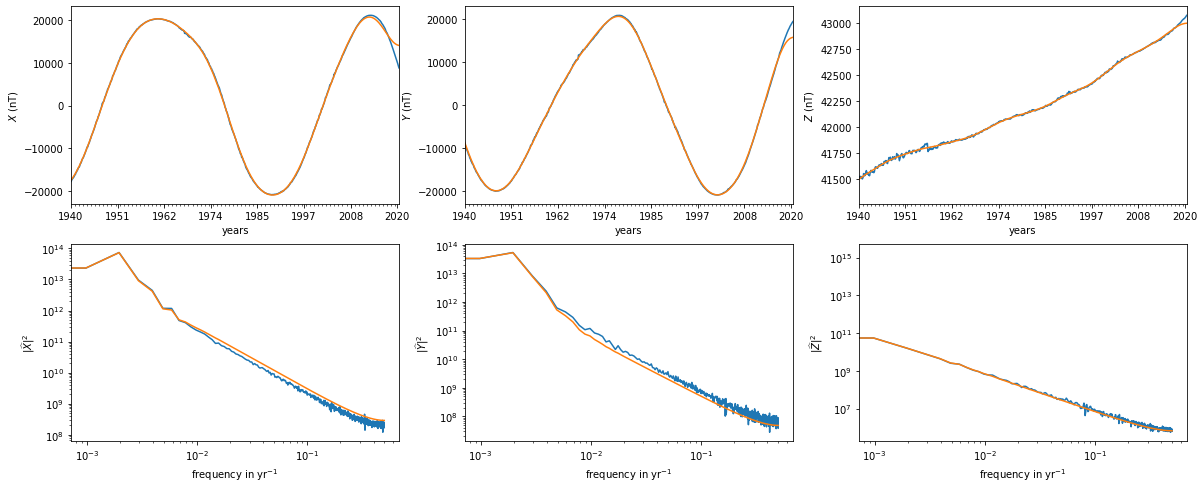

In [37]:
#
T_long  = 11 # in yr

f_samp = 1./t_samp   
f_nyq =  f_samp / 2
#
f_low_cut =  (1./T_long)          # in year^{-1}
w_low_cut =  f_low_cut / f_nyq    # angular frequency
#
#f_high_cut = (1./T_short)         # in year^{-1}
#w_high_cut = f_high_cut / f_nyq   # angular frequency

# define filter properties
#
#b,a = signal.butter(2, [w_low_cut,w_high_cut], 'band')
b,a = signal.butter(2, w_low_cut, 'low')
#
# apply filter to signal (twice, to avoid phasing) 
#
xrecons = signal.filtfilt(b,a,xcomp)
yrecons = signal.filtfilt(b,a,ycomp)
zrecons = signal.filtfilt(b,a,zcomp)
#
# compute its Fourier transform
#
xrecons_hat = np.fft.rfft(xrecons)
yrecons_hat = np.fft.rfft(yrecons)
zrecons_hat = np.fft.rfft(zrecons)
#
# these are the associated frequencies (useful for subsequent plot)
freq_xrecons = np.fft.rfftfreq(len(xrecons)) # in year^{-1} 
freq_yrecons = np.fft.rfftfreq(len(yrecons))
freq_zrecons = np.fft.rfftfreq(len(zrecons))
# plot the timeseries and its power spectrum, as well as those
# of the filtered signal 
#
fig, axs = plt.subplots(2,3, figsize=(20,8))
#

# Plot timeseries of X
axs[0,0].plot(epoch,xcomp)
axs[0,0].plot(epoch,xrecons)
axs[0,1].plot(epoch,ycomp)
axs[0,1].plot(epoch,yrecons)
axs[0,2].plot(epoch,zcomp)
axs[0,2].plot(epoch,zrecons)
# format the ticks
axs[0,0].xaxis.set_minor_locator(years)
axs[0,1].xaxis.set_minor_locator(years)
axs[0,2].xaxis.set_minor_locator(years)
axs[0,0].xaxis.set_major_formatter(yearsFmt)
axs[0,1].xaxis.set_major_formatter(yearsFmt)
axs[0,2].xaxis.set_major_formatter(yearsFmt)
datemin = dts.datestr2num('1940-01-01')
datemax = dts.datestr2num('2020-12-31')
axs[0,0].set_xlim(datemin, datemax)
axs[0,1].set_xlim(datemin, datemax)
axs[0,2].set_xlim(datemin, datemax)
axs[0,0].set_xticks(np.arange(datemin,datemax,4200))
axs[0,1].set_xticks(np.arange(datemin,datemax,4200))
axs[0,2].set_xticks(np.arange(datemin,datemax,4200))
axs[0,0].set_xlabel('years')
axs[0,1].set_xlabel('years')
axs[0,2].set_xlabel('years')
axs[0,0].set_ylabel('$X$ (nT)')
axs[0,1].set_ylabel('$Y$ (nT)')
axs[0,2].set_ylabel('$Z$ (nT)')
#
## Plot the power spectral density of X
axs[1,0].loglog(freq_x, abs(x_hat)**2)
axs[1,0].loglog(freq_xrecons, abs(xrecons_hat)**2)
axs[1,1].loglog(freq_y, abs(y_hat)**2)
axs[1,1].loglog(freq_yrecons, abs(yrecons_hat)**2)
axs[1,2].loglog(freq_z, abs(z_hat)**2)
axs[1,2].loglog(freq_zrecons, abs(zrecons_hat)**2)
axs[1,0].set_xlabel('frequency in yr$^{-1}$')
axs[1,1].set_xlabel('frequency in yr$^{-1}$')
axs[1,2].set_xlabel('frequency in yr$^{-1}$')
axs[1,0].set_ylabel(r'|$\widehat{X}$|$^2$')
axs[1,1].set_ylabel(r'|$\widehat{Y}$|$^2$')
axs[1,2].set_ylabel(r'|$\widehat{Z}$|$^2$')
# show the figure
plt.show()

These signals are associated in the Fourier spectra with peaks at 1 year and half-year periods (A large part of the signals generated in the magnetosphere is concentrated in the 𝑍 component). 